In [149]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from tqdm.notebook import tqdm

### LoRA on Linear Model under Random Initialization

#### Training

In [154]:
# Parameters
input_dim = 100 # d
output_dim = 100 # k
epochs = 1500
var = [1., 0.1, 1e-2, 1e-3, 1e-4]  # Different variances to evaluate
r = 8 # LoRA rank
K = 4 # Rank of ground truth matrix

# List for records
loss_traces = {}
risk_traces = {}
align_traces = {}

# Generate downstream weight, pre-trained weight
theta = torch.randn(input_dim, output_dim)
P, D, Q = torch.svd(theta)
theta_k = P[:,:K] @ Q[:,:K].T # downstream weight
W0 = torch.randn(input_dim, output_dim) # pre-trained weight

# Data generation
n_samples = 16 * input_dim # N
mean = np.zeros(input_dim)
covariance = np.eye(input_dim)
X = np.random.multivariate_normal(mean, covariance, n_samples)
X = torch.tensor(X, dtype=torch.float32)
# Labels generation
y = X @ (W0 + theta_k)

# One-step full gradient
Xy = (1 / n_samples) * X.T @ (y - X @ W0)
L, S, R = torch.svd(Xy, some=False)

# Training loop for different variances
for g in var:
    # Initialize A and B
    variance = g
    std_dev = variance ** 0.5
    A = torch.randn(input_dim, r) * std_dev
    A0 = A.clone().detach()

    B = torch.zeros(r, output_dim)
    B0 = B.clone().detach()

    # compute left singular matrix og one-step full gradient
    U, _, _ = torch.svd(Xy, some=False)

    # Record traces
    current_loss_trace = []
    current_align_trace = []
    current_risk_trace = []

    # Record initial loss
    loss = (1 / (2 * n_samples)) * torch.norm(X @ (W0 + A @ B) - y) ** 2
    current_loss_trace.append(loss.item())

    # lr scheduler
    lamb = 1. # lora plus ratio
    alpha  = 1. / 64.
    beta = lamb * alpha

    for epoch in tqdm(range(epochs)):

        A1 = A
        B1 = B

        # GD
        A = A1 - (alpha / n_samples) * X.T @ (X @ (W0 + A1 @ B1) - y) @ B1.T
        B = B1 - (beta / n_samples) * A1.T @ X.T @ (X @ (W0 + A1 @ B1) - y)

        # losses computation
        loss = (1 / (2 * n_samples)) * torch.norm(X @ (W0 + A @ B) - y) ** 2
        current_loss_trace.append(loss.item())

        # compute left singular matrix of A
        UA, _, _ = torch.svd(A, some = False)

        # principal angle between top-k* subspace of At and bottom-(d-k*) subspace of one-step full gradient
        DA = torch.svd(U[:,K:].T @ UA[:,:K]).S.max()
        current_align_trace.append(DA.item())

        # risk
        risk = torch.norm(A1 @ B1 - theta_k)**2. / 2.
        current_risk_trace.append(risk.item())

    loss_traces[g] = current_loss_trace
    risk_traces[g] = current_risk_trace
    align_traces[g] = current_align_trace

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

#### Visualization

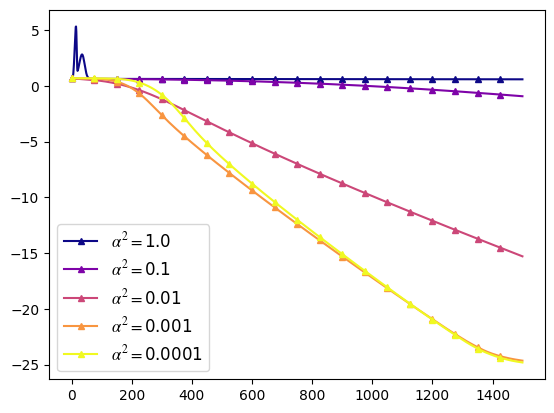

In [158]:
# Risk curve

n_lines = 5
cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0., 1., n_lines))
i = 0

step = max(1, epochs // 20)  # Adjust step size for markers
marker_indice = range(0, epochs, step)

for g, risk in risk_traces.items():
  plt.plot(np.log(risk), marker="^", linewidth=1.5, markersize=5, markevery = marker_indice, label = r"$\alpha^{2}=$"+str(g), color=colors[i])
  i = i + 1
plt.legend(fontsize=12)
plt.show()

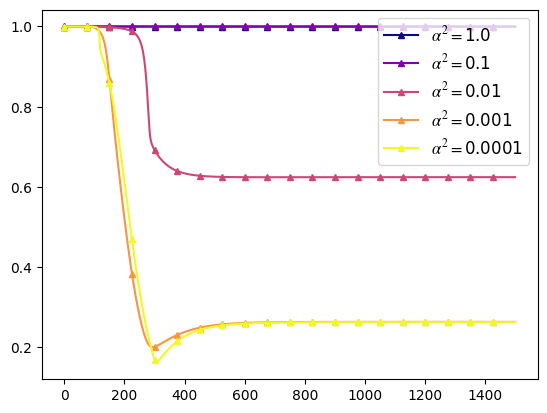

In [160]:
# Alignment curve

n_lines = 5
cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0., 1., n_lines))
i = 0

step = max(1, epochs // 20)  # Adjust step size for markers
marker_indice = range(0, epochs, step)

for g, angle in align_traces.items():
  plt.plot(angle, marker="^", linewidth=1.5, markersize=5, markevery = marker_indice, label = r"$\alpha^{2}=$"+str(g), color=colors[i])
  i = i + 1
plt.legend(loc="upper right", fontsize=12)
plt.show()

### Spectral Initialization for Linear Model

In [172]:
def pseudo_inverse(matrix, K):
    # Perform SVD
    U, S, V = torch.svd(matrix, some=False)

    # Calculate the reciprocal of non-zero singular values
    S_pseudo_inv = torch.zeros_like(S)
    S_pseudo_inv[:K] = 1 / S[:K]

    # Construct pseudo-inverse of the diagonal matrix
    S_pseudo_inv_matrix = torch.diag(S_pseudo_inv)

    # Compute the pseudo-inverse
    pseudo_inv_matrix = V @ S_pseudo_inv_matrix @ U.T
    return pseudo_inv_matrix

def spectral_initialization(name, G, stable_param, r):
  if name == "Spectral-init":
    L, S, R = torch.svd(G, some=False)
    A = L[:,:r] @ torch.diag(torch.sqrt(S[:r]))
    B = torch.diag(torch.sqrt(S[:r])) @ R[:,:r].T
    return A, B

  else:
    L, S, R = torch.svd(-G, some=False)
    gamma = torch.sqrt(torch.sqrt(torch.tensor(G.shape[1]))) / torch.sqrt(torch.tensor([stable_param]))
    if name == "LoRA-One":
      A = gamma * L[:,:r]
      B = gamma * R[:,:r].T

      return A, B
    if name == "LoRA-GA":
      A = gamma * L[:,:r]
      B = gamma * R[:,r:2*r].T

      return A, B
    else:
      print("Invalid name")
      return None

In [191]:
# Parameters
input_dim = 100 # d
output_dim = 100 # k
epochs = 100
methods = ["Spectral-init", "LoRA-One", "LoRA-GA"]  # Different variances to evaluate
r = 8 # LoRA rank
K = 4 # Downstream rank

# List for records
loss_traces = {}
risk_traces = {}

# Generate downstream weight, pre-trained weight
theta = torch.randn(input_dim, output_dim)
P, _, Q = torch.svd(theta)
D = torch.tensor([4., 3., 2., 1.])
theta_k = P[:,:K] @ torch.diag(D[:K]) @ Q[:,:K].T # downstream weight
theta_k = theta_k / torch.svd(theta_k).S.max()
W0 = torch.randn(input_dim, output_dim) # pre-trained weight

# Data generation
n_samples = 16 * input_dim # N
mean = np.zeros(input_dim)
covariance = np.eye(input_dim)
for g in methods:
    X = np.random.multivariate_normal(mean, covariance, n_samples)
    X = torch.tensor(X, dtype=torch.float32)
    # Labels generation
    y = X @ (W0 + theta_k)

    # One-step full gradient
    Xy = (1 / n_samples) * X.T @ (y - X @ W0)
    # Initialize A and B
    A, B = spectral_initialization(g, Xy, 4., r)

    # Record traces
    current_loss_trace = []
    current_risk_trace = []

    if g != "Spectral-init":
      W_f = W0
      W0 = W0 - A @ B

    # Record initial loss
    loss = (1 / (2 * n_samples)) * torch.norm(X @ (W0 + A @ B) - y) ** 2
    current_loss_trace.append(loss.item())

    # lr scheduler
    lamb = 1.
    alpha  = 0.5
    beta = lamb * alpha

    for epoch in tqdm(range(epochs)):

        A1 = A
        B1 = B

        # Prec-GD
        A = A1 - (alpha / n_samples) * X.T @ (X @ (W0 + A1 @ B1) - y) @ B1.T @ torch.inverse(B1 @ B1.T + 1e-3 * torch.eye(r))
        B = B1 - (beta / n_samples) * torch.inverse(A1.T @ A1 + 1e-3 * torch.eye(r)) @ A1.T @ X.T @ (X @ (W0 + A1 @ B1) - y)

        # losses computation
        loss = (1 / (2 * n_samples)) * torch.norm(X @ (W0 + A @ B) - y) ** 2
        current_loss_trace.append(loss.item())

        # risk
        if g == "Spectral-init":
          risk = torch.norm(A1 @ B1 - theta_k)**2. / 2.
          current_risk_trace.append(risk.item())
        else:
          risk = torch.norm(W0 + A1 @ B1 - theta_k - W_f) ** 2. / 2.
          current_risk_trace.append(risk.item())

    loss_traces[g] = current_loss_trace
    risk_traces[g] = current_risk_trace

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

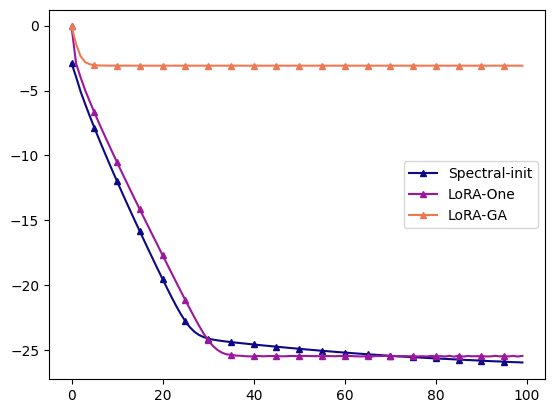

In [192]:
# Risk curve

n_lines = 4
cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0., 1., n_lines))
i = 0

step = max(1, epochs // 20)  # Adjust step size for markers
marker_indice = range(0, epochs, step)

for g, risk in risk_traces.items():
  plt.plot(np.log(risk), marker="^", linewidth=1.5, markersize=5, markevery = marker_indice, label = g, color=colors[i])
  i = i + 1
plt.legend()
plt.show()

### Phase Transition of GD trajectories

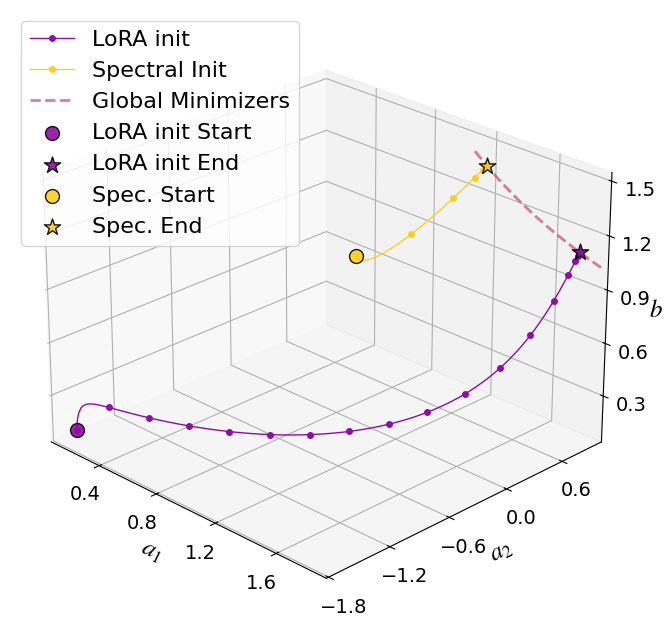

In [153]:
# Set random seed for reproducibility
torch.manual_seed(7) # 3 7 18

# Generate data
beta = torch.tensor([2.0, 1.0])
x_data = torch.randn(4, 2)
y_data = x_data @ beta

def train_model(a_init, b_init, lr=0.1, steps=1000):
    a = a_init.clone().requires_grad_(True)
    b = b_init.clone().requires_grad_(True)
    trajectory = []

    for _ in range(steps):
        pred = b * (x_data @ a)
        loss = (1/8) * torch.sum((y_data - pred)**2)

        loss.backward()

        with torch.no_grad():
            a -= lr * a.grad
            b -= lr * b.grad
            a.grad.zero_()
            b.grad.zero_()

        trajectory.append([a[0].item(), a[1].item(), b.item()])

    return np.array(trajectory)

# Initializations and training
a1 = torch.randn(2) * 1.
b1 = torch.tensor(0.0)
traj1 = train_model(a1, b1)

g = (1./4.) * (((y_data[0])**2) * x_data[0,:] + ((y_data[1])**2) * x_data[1,:] + ((y_data[2])**2) * x_data[2,:] + ((y_data[3])**2) * x_data[3,:]).t()
gnorm = torch.norm(g)
a2 = g / torch.sqrt(gnorm)
b2 = torch.sqrt(gnorm)
traj2 = train_model(a2, b2, lr=0.1)

# Create plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.cm.plasma
step = max(1, len(traj1) // 80)  # Adjust step size for markers
marker_indices = range(0, len(traj1), step)
# Plot trajectories first
ax.plot(traj1[:,0], traj1[:,1], traj1[:,2],
        c=cmap(0.3), marker='o', markersize=4, linewidth=1, markevery=marker_indices,
        label='LoRA init')
ax.plot(traj2[:,0], traj2[:,1], traj2[:,2],
        c=cmap(0.9), marker='o', markersize=4, linewidth=1, markevery=marker_indices,
        label='Spectral Init')

# Calculate axis limits based on trajectories
all_points = np.vstack([traj1, traj2])
x_min, x_max = all_points[:,0].min(), all_points[:,0].max()
y_min, y_max = all_points[:,1].min(), all_points[:,1].max()
z_min, z_max = all_points[:,2].min(), all_points[:,2].max()

# Add 15% padding
pad_percent = 0.05
x_pad = pad_percent * (x_max - x_min)
y_pad = pad_percent * (y_max - y_min)
z_pad = pad_percent * (z_max - z_min)

x_lim = (x_min - x_pad, x_max + x_pad)
y_lim = (y_min - y_pad, y_max + y_pad)
z_lim = (z_min - z_pad, z_max + z_pad)

# Generate hyperplane within calculated limits
t = np.linspace(z_lim[0], z_lim[1], 1000)
t = t[np.abs(t) > 0.01]  # Avoid division by zero
x_gm = 2/t
y_gm = 1/t
z_gm = t

# Filter points within visualization bounds
mask = (x_gm >= x_lim[0]) & (x_gm <= x_lim[1]) & (y_gm >= y_lim[0]) & (y_gm <= y_lim[1])
ax.plot(x_gm[mask], y_gm[mask], z_gm[mask], c=cmap(0.5),
        linestyle='--', linewidth=2, alpha=0.7,
        label='Global Minimizers')

for traj, color, label in [(traj1, cmap(0.3), 'LoRA init'),
                             (traj2, cmap(0.9), 'Spec.')]:
        # Start point (big circle)
        ax.scatter(traj[0,0], traj[0,1], traj[0,2],
                 c=[color], s=100, marker='o', edgecolor='k',
                 label=f'{label} Start', alpha=0.9)
        # End point (big star)
        ax.scatter(traj[-1,0], traj[-1,1], traj[-1,2],
                 c=[color], s=150, marker='*', edgecolor='k',
                 label=f'{label} End', alpha=0.9)

start_x, start_y, start_z = traj2[0]

# Set axis limits
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_zlim(z_lim)

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="z", labelsize=14)

# Suppose 'ax' is your 3D axis object, you can do:
ax.xaxis.set_major_locator(mticker.MaxNLocator(5))  # Up to 5 ticks on X
ax.yaxis.set_major_locator(mticker.MaxNLocator(5))  # Up to 5 ticks on Y
ax.zaxis.set_major_locator(mticker.MaxNLocator(5))  # Up to 5 ticks on Z

# Final touches
plt.rcParams["mathtext.fontset"] = "stix"
ax.set_xlabel(r'$a_1$', fontsize=18)
ax.set_ylabel(r'$a_2$', fontsize=18)
ax.set_zlabel(r'$b$', fontsize=18)
ax.view_init(elev=25, azim=-45)
ax.zaxis.labelpad = -0.5
plt.legend(loc="upper left", fontsize=16)

plt.show()